In [1]:
import pandas as pd, json, joblib, time
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix)

TRAIN_CSV  = Path('train_10s_window_2s_stride.csv')
HOLD_CSV   = Path('holdout_10s_window_2s_stride.csv')

train_df = pd.read_csv(TRAIN_CSV)
hold_df  = pd.read_csv(HOLD_CSV)

FEATURE_COLS = [
    c for c in train_df.columns if c not in (
        'subject', 'trial', 'window',
        'valence', 'arousal',
        'valence_label', 'arousal_label')
]

LABELS = ['valence', 'arousal']      

# ---------- Pipeline + GridSearch  ---------------
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm',    SVC(kernel='rbf', class_weight='balanced'))
])

param_grid = {
    'svm__C':     [0.1, 1, 10, 100],
    'svm__gamma': [1e-3, 1e-2, 1e-1]
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ---------- dictionary for saving results -----------------------
all_cv   = {}
holdouts = {}
best_models = {}

for label in LABELS:
    label_col = f'{label}_label'
    if label_col not in train_df.columns:
        raise ValueError(f'column {label_col} does not exist in-CSV!')

    X_train, y_train = train_df[FEATURE_COLS], train_df[label_col].values
    X_hold,  y_hold  = hold_df[FEATURE_COLS],  hold_df[label_col].values

    cv_folds, best_f1, best_model = [], 0, None
    print(f"\n [{label.upper()}] Nested CV (5 folds × GridSearch)\n")
    t0 = time.time()

    for i, (tr_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
        grid = GridSearchCV(pipe, param_grid,
                            scoring='f1', cv=inner_cv,
                            n_jobs=-1, verbose=0)
        grid.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        y_pred = grid.best_estimator_.predict(X_train.iloc[val_idx])

        acc = accuracy_score(y_train[val_idx], y_pred)
        f1  = f1_score(y_train[val_idx], y_pred, zero_division=0)

        cv_folds.append({
            'fold': i,
            'best_params': grid.best_params_,
            'accuracy': acc,
            'precision': precision_score(y_train[val_idx], y_pred, zero_division=0),
            'recall': recall_score(y_train[val_idx], y_pred, zero_division=0),
            'f1_score': f1,
            'confusion_matrix': confusion_matrix(y_train[val_idx], y_pred).tolist()
        })

        print(f"[{label.upper()}] Fold {i}/5 | "
              f"Acc={acc:.3f}  F1={f1:.3f}  "
              f"(C={grid.best_params_['svm__C']}, γ={grid.best_params_['svm__gamma']})")

        if f1 > best_f1:
            best_f1, best_model = f1, grid.best_estimator_

    print(f" [{label.upper()}] CV done in {time.time()-t0:.1f}s | Best F1={best_f1:.3f}")

    # --- Hold-out ---
    y_hold_pred = best_model.predict(X_hold)
    hold_metrics = {
        'accuracy':  accuracy_score(y_hold, y_hold_pred),
        'precision': precision_score(y_hold, y_hold_pred, zero_division=0),
        'recall':    recall_score(y_hold, y_hold_pred, zero_division=0),
        'f1_score':  f1_score(y_hold, y_hold_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_hold, y_hold_pred).tolist()
    }
    print(f" [{label.upper()}] Hold-out → Acc={hold_metrics['accuracy']:.3f}, "
          f"F1={hold_metrics['f1_score']:.3f}\n")

    # --- saving ---
    all_cv[label]   = cv_folds
    holdouts[label] = hold_metrics
    best_models[label] = best_model
    joblib.dump(best_model, f'best_{label}_svm_10s_window_2s_stride.joblib')

# ---------- Pairwise-Accuracy on Hold-out -----------------
true_pairs = list(zip(hold_df['valence_label'], hold_df['arousal_label']))
pred_pairs = list(zip(
    best_models['valence'].predict(hold_df[FEATURE_COLS]),
    best_models['arousal'].predict(hold_df[FEATURE_COLS])
))
pair_acc = sum(int(t == p) for t, p in zip(true_pairs, pred_pairs)) / len(true_pairs)
print(f" PAIRWISE accuracy (Valence+Arousal) on Hold-out = {pair_acc:.3f}")

# ---------- overall report -------------------------------
report = {
    'cv_folds': all_cv,
    'holdout':  holdouts,
    'pairwise_accuracy': pair_acc
}
with open('svm_grid_results_10s_window_2s_stride.json', 'w', encoding='utf-8') as fp:
    json.dump(report, fp, indent=4)

print("\n All metrics saved → svm_grid_results_10s_window_2s_stride.json")



 [VALENCE] Nested CV (5 folds × GridSearch)

[VALENCE] Fold 1/5 | Acc=0.890  F1=0.907  (C=100, γ=0.1)
[VALENCE] Fold 2/5 | Acc=0.871  F1=0.891  (C=100, γ=0.1)
[VALENCE] Fold 3/5 | Acc=0.887  F1=0.905  (C=100, γ=0.1)
[VALENCE] Fold 4/5 | Acc=0.880  F1=0.898  (C=100, γ=0.1)
[VALENCE] Fold 5/5 | Acc=0.886  F1=0.904  (C=100, γ=0.1)
 [VALENCE] CV done in 7559.2s | Best F1=0.907
 [VALENCE] Hold-out → Acc=0.884, F1=0.902


 [AROUSAL] Nested CV (5 folds × GridSearch)

[AROUSAL] Fold 1/5 | Acc=0.897  F1=0.895  (C=100, γ=0.1)
[AROUSAL] Fold 2/5 | Acc=0.899  F1=0.897  (C=100, γ=0.1)
[AROUSAL] Fold 3/5 | Acc=0.893  F1=0.891  (C=100, γ=0.1)
[AROUSAL] Fold 4/5 | Acc=0.898  F1=0.896  (C=100, γ=0.1)
[AROUSAL] Fold 5/5 | Acc=0.894  F1=0.892  (C=100, γ=0.1)
 [AROUSAL] CV done in 6994.0s | Best F1=0.897
 [AROUSAL] Hold-out → Acc=0.901, F1=0.900

 PAIRWISE accuracy (Valence+Arousal) on Hold-out = 0.813

 All metrics saved → svm_grid_results_10s_window_2s_stride.json


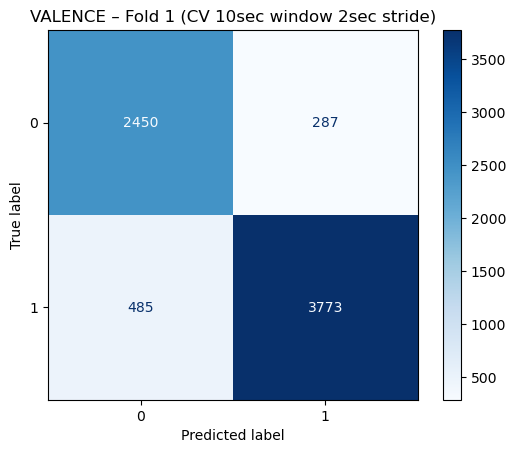

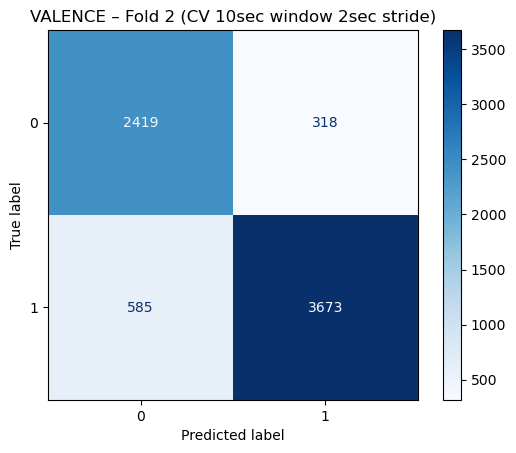

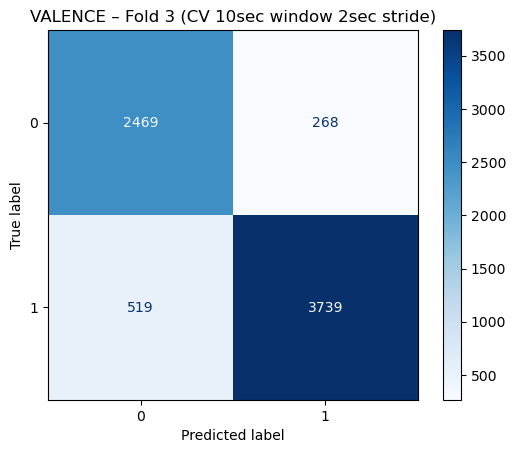

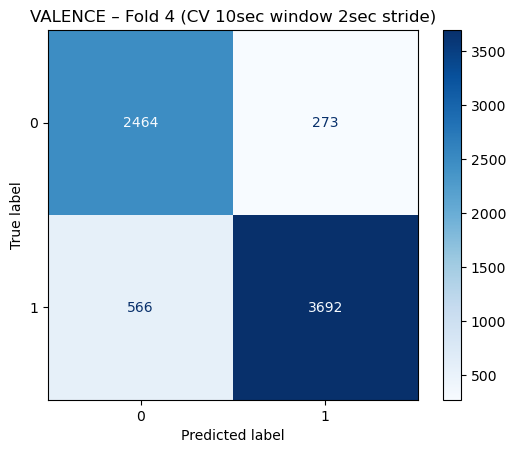

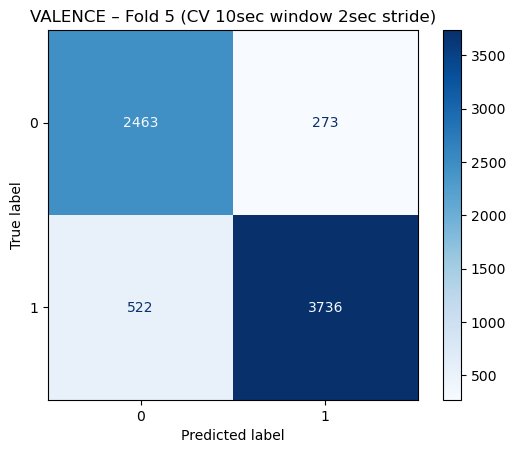

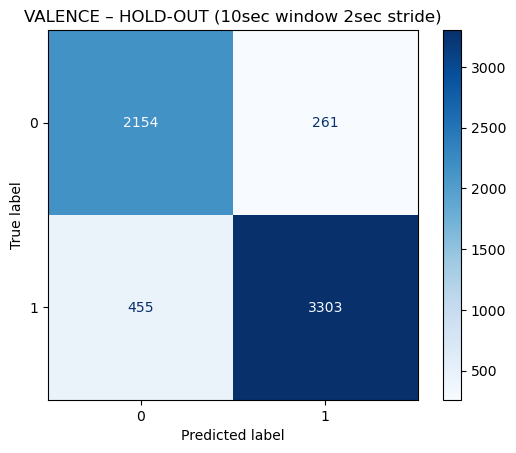

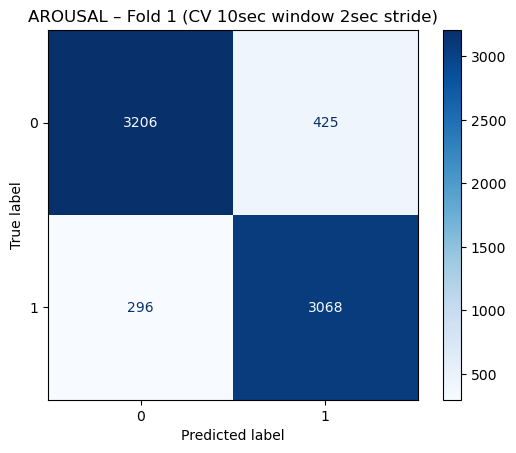

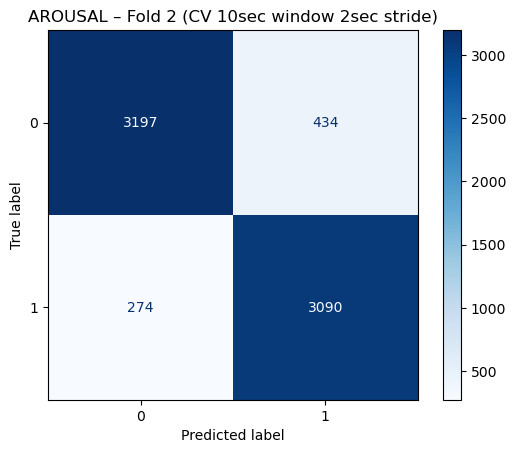

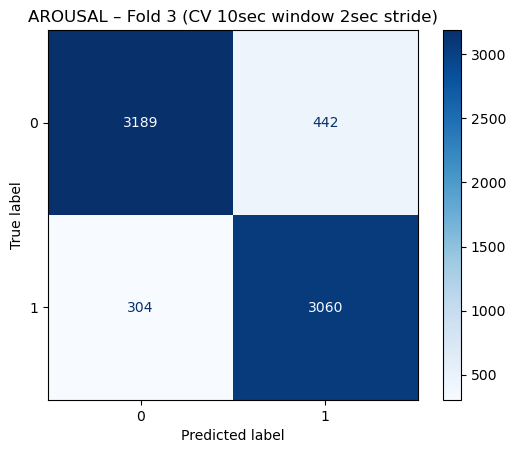

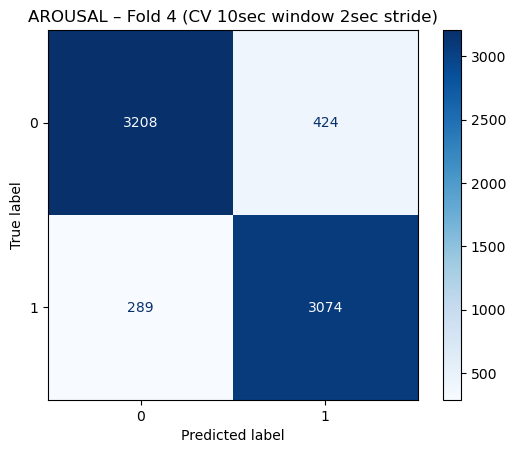

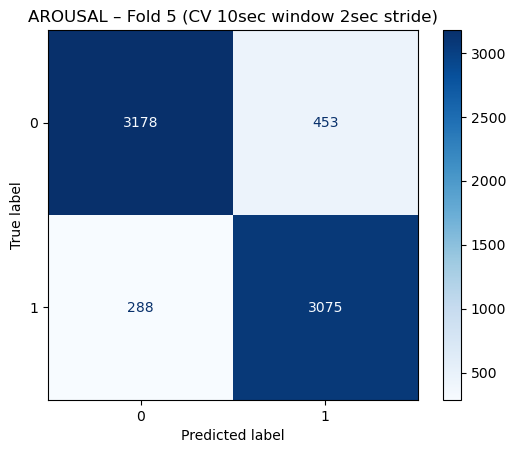

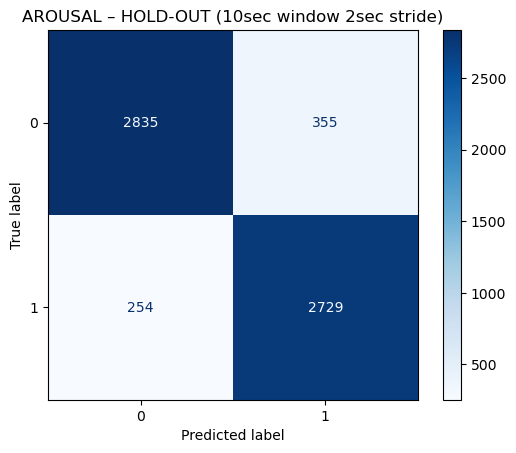

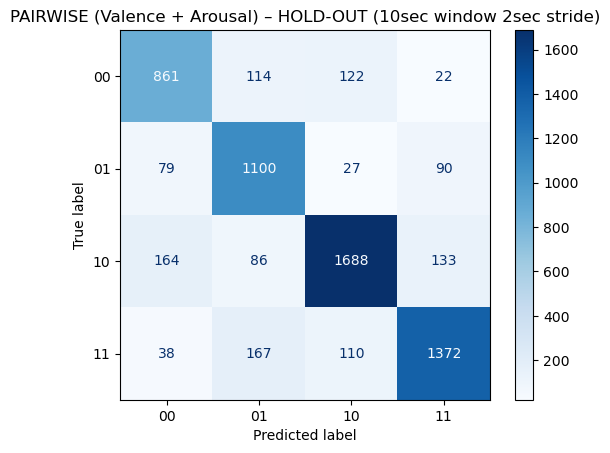

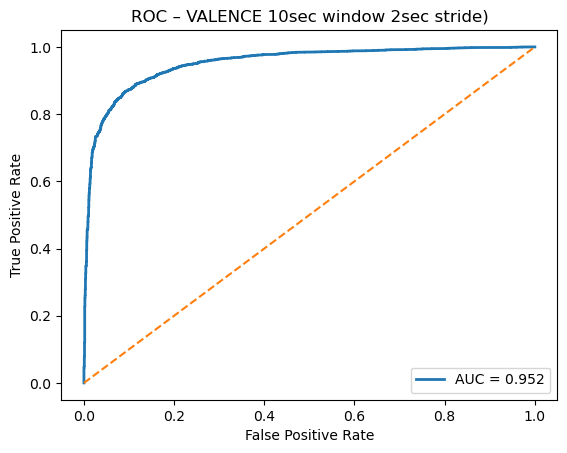

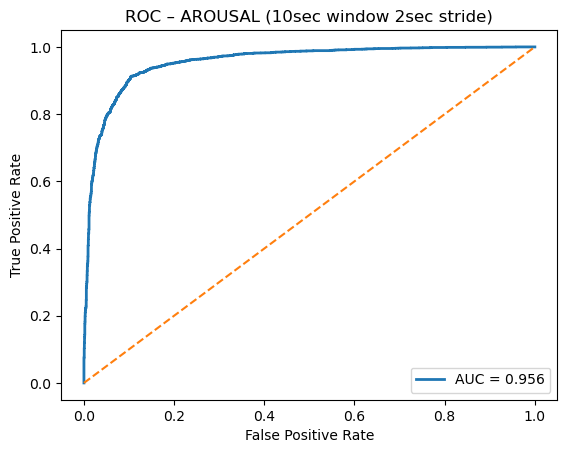

In [2]:
# ==========================================================
# plotting results (SVM – 5sec window)
# ==========================================================
import json, joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc)

# ----- loading files -------------
RESULTS_JSON = Path('svm_grid_results_10s_window_2s_stride.json')
VAL_MODEL    = Path('best_valence_svm_10s_window_2s_stride.joblib')
ARO_MODEL    = Path('best_arousal_svm_10s_window_2s_stride.joblib')
HOLD_CSV     = Path('holdout_10s_window_2s_stride.csv')

# ----- loading data  ---------
with RESULTS_JSON.open() as fp:
    res = json.load(fp)

hold_df  = pd.read_csv(HOLD_CSV)
X_hold   = hold_df[[c for c in hold_df.columns if c not in (
    'subject','trial','window','valence','arousal',
    'valence_label','arousal_label')]]

# ==========================================================
# 1. Confusion Matrix plot function
# ==========================================================
def plot_cm(cm, title, labels=None):
    n_classes = cm.shape[0]
    if labels is None:
        labels = list(range(n_classes))
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
    ax.set_title(title)
    plt.show()

# ==========================================================
# 2. confusion matrix for each fold and hold-out
# ==========================================================
for label in ['valence', 'arousal']:
    folds = res['cv_folds'][label]
    for fold in folds:
        cm = np.array(fold['confusion_matrix'])
        title = f"{label.upper()} – Fold {fold['fold']} (CV 10sec window 2sec stride)"
        plot_cm(cm, title)

    # Hold-out
    best_m = joblib.load(VAL_MODEL if label=='valence' else ARO_MODEL)
    y_true = hold_df[f'{label}_label'].values
    y_pred = best_m.predict(X_hold)
    cm_hold = confusion_matrix(y_true, y_pred)
    plot_cm(cm_hold, f"{label.upper()} – HOLD-OUT (10sec window 2sec stride)")

# ==========================================================
# 3. pairwise confusion matrix (Valence+Arousal)
# ==========================================================
pair_true = list(zip(hold_df['valence_label'], hold_df['arousal_label']))
pair_pred = list(zip(
    joblib.load(VAL_MODEL).predict(X_hold),
    joblib.load(ARO_MODEL).predict(X_hold)
))

# mapping (0/1,0/1) -> 0..3
map_pair = {(0,0):0, (0,1):1, (1,0):2, (1,1):3}
y_true_pair = [map_pair[t] for t in pair_true]
y_pred_pair = [map_pair[p] for p in pair_pred]
cm_pair = confusion_matrix(y_true_pair, y_pred_pair)

pair_labels = ["00", "01", "10", "11"]
plot_cm(cm_pair, "PAIRWISE (Valence + Arousal) – HOLD-OUT (10sec window 2sec stride)",
        labels=pair_labels)

# ==========================================================
# 4. ROC curves on hold-out
# ==========================================================
def plot_roc(model, X, y, title):
    scores = model.decision_function(X)
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(joblib.load(VAL_MODEL), X_hold,
         hold_df['valence_label'].values,
         "ROC – VALENCE 10sec window 2sec stride)")

plot_roc(joblib.load(ARO_MODEL), X_hold,
         hold_df['arousal_label'].values,
         "ROC – AROUSAL (10sec window 2sec stride)")


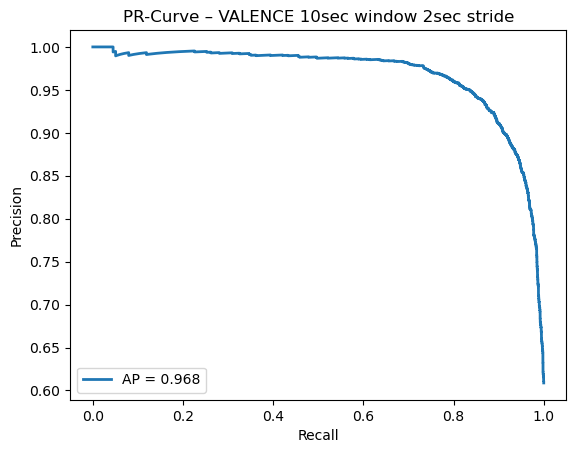

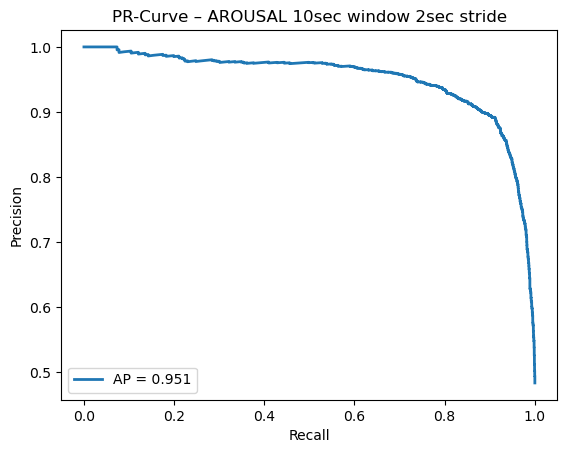

In [3]:
# ================================================
# Precision-Recall for SVM
# ================================================
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd, joblib
from sklearn.metrics import (precision_recall_curve,
                             average_precision_score)

# ----- file paths -----
VAL_MODEL = Path("best_valence_svm_10s_window_2s_stride.joblib")
ARO_MODEL = Path("best_arousal_svm_10s_window_2s_stride.joblib")
HOLD_CSV  = Path("holdout_10s_window_2s_stride.csv")

# ----- load data -----
hold_df = pd.read_csv(HOLD_CSV)
X_hold  = hold_df[[c for c in hold_df.columns if c not in (
    "subject","trial","window",
    "valence","arousal",
    "valence_label","arousal_label")]]

# ----- helper to get continuous scores from SVM -----
def svm_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    return model.decision_function(X)

def plot_pr(model, X, y, title):
    scores = svm_scores(model, X)
    precision, recall, _ = precision_recall_curve(y, scores)
    ap = average_precision_score(y, scores)
    plt.figure()
    plt.plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

# ----- curves -----
plot_pr(joblib.load(VAL_MODEL), X_hold,
        hold_df["valence_label"].values,
        "PR-Curve – VALENCE 10sec window 2sec stride")

plot_pr(joblib.load(ARO_MODEL), X_hold,
        hold_df["arousal_label"].values,
        "PR-Curve – AROUSAL 10sec window 2sec stride")
